In [105]:
#Importing libraries

import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [84]:
# import required modules
import firebase_admin
from firebase_admin import db, credentials

In [98]:
# authenticate to firebase
cred = credentials.Certificate("credentials.json")
firebase_admin.initialize_app(cred, {"databaseURL": "https://plm-db-d53cc-default-rtdb.firebaseio.com/"})

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [86]:
# creating reference to root node
ref = db.reference("/")

In [88]:
ref = db.reference('/Pictures Data')

# Get the data
data = ref.get()

In [92]:
#This code snippet looks into our database and calculates the most recently added image in the database to run it through out Model

from datetime import datetime
import dateutil.parser

# Initialize a variable to keep track of the latest time
latest_time = None

# Initialize variables to store the key and imageUrl of the record with the latest time
latest_key = None
latest_image_url = None

# Iterate over all records in the data
for key, record in data.items():
    # Parse the time field of the record
    time_str = record['time']
    time = dateutil.parser.parse(time_str)

    # If this record's time is later than the latest time we've seen so far,
    # update our latest time, key, and imageUrl
    if latest_time is None or time > latest_time:
        latest_time = time
        latest_key = key
        latest_image_url = record['imageUrl']

print("Latest Key:", latest_key)
print("Latest Image URL:", latest_image_url)



ParserError: Unknown string format: Tue Jan 09 2024 16:20:22 GMT-0500 (Eastern Standard Time)

In [91]:
#Once we have highlighted the most recent image this code snippet downloads the image to our notebook files.
import requests

def download_image(image_url, image_path):
    response = requests.get(image_url)
    with open(image_path, 'wb') as file:
        file.write(response.content)

# Usage
image_url = first_image_url  # replace with your image URL
image_path = r'C:\Users\HP\TestSetFYP\train\image1.jpg'  # replace with your desired path and filename
download_image(image_url, image_path)
  # replace with your desired path

In [106]:
%matplotlib inline

In [107]:
#Initializing our model

# Device
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Architecture
NUM_CLASSES = 2

In [108]:
#Highlighting and creating our training set
import os

num_train_correct = len([i for i in os.listdir(os.path.join('TestSetFYP', 'train')) 
                      if i.endswith('.jpg') and i.startswith('correct')])

num_train_defect = len([i for i in os.listdir(os.path.join('TestSetFYP', 'train')) 
                      if i.endswith('.jpg') and i.startswith('defect')])

print(f'Training set correct: {num_train_correct}')
print(f'Training set defect: {num_train_defect}')

Training set correct: 18
Training set defect: 25


(1600, 900, 3)


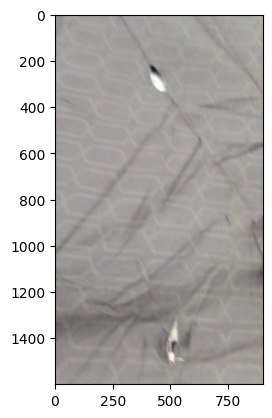

In [109]:
#Checking a random image from our training set to make sure our code is working on par so far.

img = Image.open(os.path.join('TestSetFYP','train', 'defect.10.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [110]:
#Creating directories for our test and valid folder

if not os.path.exists(os.path.join('TestSetFYP', 'test')):
    os.mkdir(os.path.join('TestSetFYP', 'test'))

if not os.path.exists(os.path.join('TestSetFYP', 'valid')):
    os.mkdir(os.path.join('TestSetFYP', 'valid'))

In [112]:
#Splitting images for our test and valid directories
for fname in os.listdir(os.path.join('TestSetFYP', 'train')):
    if not fname.endswith('.jpg'):
        continue
    _, img_num, _ = fname.split('.')
    filepath = os.path.join('TestSetFYP', 'train', fname)
    img_num = int(img_num)
    if img_num > 120:
        os.rename(filepath, filepath.replace('train', 'test'))
    elif img_num > 99:
        os.rename(filepath, filepath.replace('train', 'valid'))

In [113]:
#Defining our naming conventions to the code. Correct has images that are non defected and vice versa for defect.
class FYPdataset(Dataset):
   

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'correct':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

    

custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                        transforms.ToTensor()])

train_dataset = FYPdataset(img_dir=os.path.join('TestSetFYP', 'train'), 
                                transform=custom_transform1)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=200, 
                          shuffle=False)

train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.5352, 0.4907, 0.4623])
Std Dev: tensor([0.1839, 0.1811, 0.1766])


In [1]:
#This code snippet acts as a data loader for the model. 
#We also perform some basic data augmentations (Rotate, flip) to enhance our dataset
#We also standardize the image size to 64x64 to effectively train our model.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = FYPdataset(img_dir=os.path.join('TestSetFYP', 'train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = FYPdataset(img_dir=os.path.join('TestSetFYP', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = FYPdataset(img_dir=os.path.join('TestSetFYP', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

NameError: name 'transforms' is not defined

In [114]:
#The model.
class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*2*2, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [2]:
#Running the model
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

NameError: name 'torch' is not defined

In [116]:
#Computing model accuracy and loss

def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 1., 1.
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/100 | Batch 000/001 | Cost: 221.7839
Epoch: 001/100 Train Acc.: 42.50% | Validation Acc.: 0.93%
Time elapsed: 0.18 min
Epoch: 002/100 | Batch 000/001 | Cost: 2159958.2500
Epoch: 002/100 Train Acc.: 42.50% | Validation Acc.: 0.93%
Time elapsed: 0.33 min
Epoch: 003/100 | Batch 000/001 | Cost: 1975.2953
Epoch: 003/100 Train Acc.: 60.00% | Validation Acc.: 100.00%
Time elapsed: 0.48 min
Epoch: 004/100 | Batch 000/001 | Cost: 1606.8429
Epoch: 004/100 Train Acc.: 60.00% | Validation Acc.: 100.00%
Time elapsed: 0.63 min
Epoch: 005/100 | Batch 000/001 | Cost: 680.7322
Epoch: 005/100 Train Acc.: 60.00% | Validation Acc.: 100.00%
Time elapsed: 0.78 min
Epoch: 006/100 | Batch 000/001 | Cost: 235.1776
Epoch: 006/100 Train Acc.: 60.00% | Validation Acc.: 100.00%
Time elapsed: 0.94 min
Epoch: 007/100 | Batch 000/001 | Cost: 27.9525
Epoch: 007/100 Train Acc.: 42.50% | Validation Acc.: 0.93%
Time elapsed: 1.08 min
Epoch: 008/100 | Batch 000/001 | Cost: 192.5170
Epoch: 008/100 Train Acc.: 42

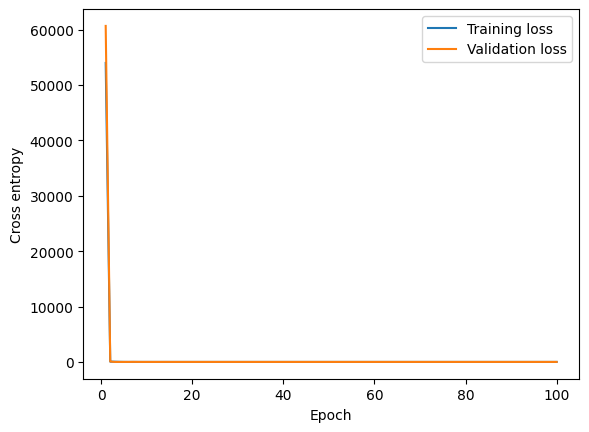

In [117]:
#Graph to represent training loss and validation loss

plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

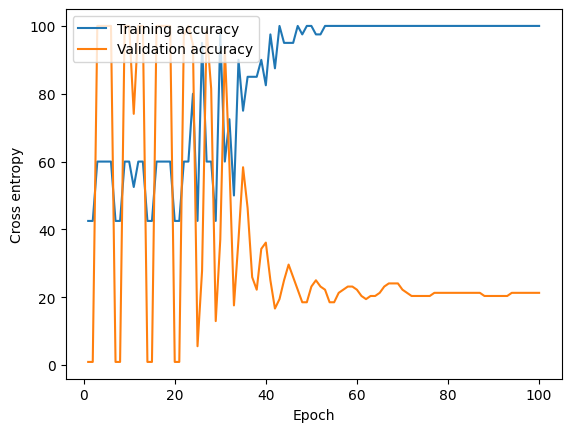

In [118]:
#Graph to represent training accuracy and validation accuracy
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [3]:
#Evaluating accuracy
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

NameError: name 'model' is not defined

In [120]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
    
unorm = UnNormalize(mean=train_mean, std=train_std)

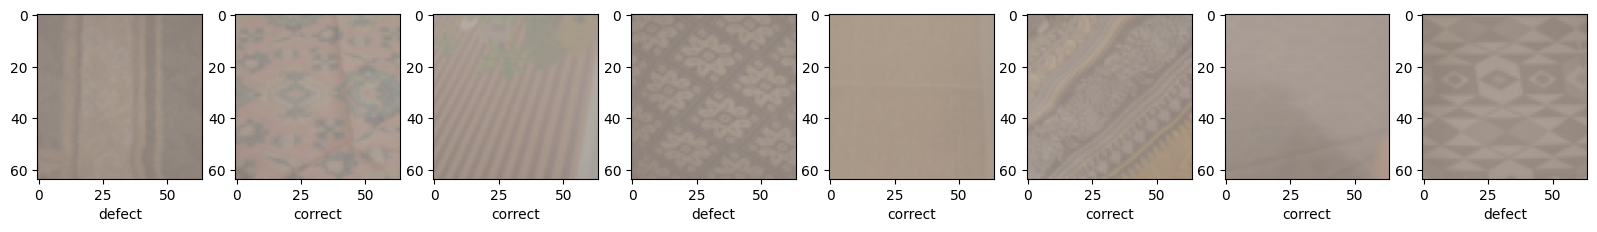

In [122]:
#getting results for 8 random images to see how the model performs in real time.

test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'defect',
     1: 'correct'}
    
fig, ax = plt.subplots(1,8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

Predicted Class: defect


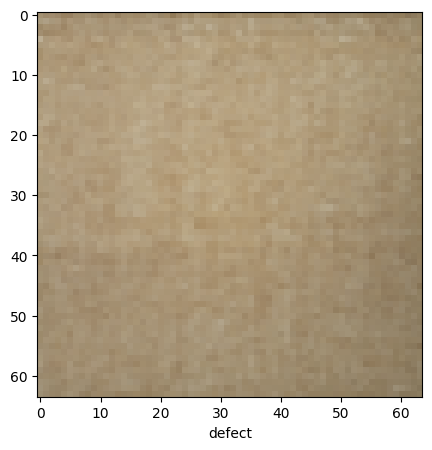

In [124]:
#Testing the image that has been uploaded and downloaded from our database (That was given to our react application)

from PIL import Image
import torchvision.transforms as transforms

# Manually upload a picture
image_path = 'TestSetFYP/train/defect.1.jpg'  # replace with your image path
image = Image.open(image_path)

# Define the transformations (this should match the transformations used when training your model)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # replace with the size you used
    transforms.ToTensor(),
    # Add any other transformations you used
])

# Apply the transformations
image = transform(image)

# Add an extra dimension because the model expects batches
image = image.unsqueeze(0)

# Move the image to the device
image = image.to(DEVICE)

# Forward pass through the model
_, predictions = model.forward(image)
predictions = torch.argmax(predictions, dim=1)

d = {0: 'correct',
     1: 'defect'}

# Plot the image and prediction
fig, ax = plt.subplots(figsize=(10, 5))
img = image.squeeze().cpu().numpy()  # Remove the extra dimension and move to cpu
img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
ax.imshow(img)
ax.set_xlabel(d[predictions.item()])

plt.show
predicted_class_index = predictions.item()
predicted_class_label = d[predicted_class_index]
print("Predicted Class:", predicted_class_label)


In [94]:
# storing the image back to the database with our result also stored in the database.
record_ref = db.reference(f'/Pictures Data/{latest_key}')

# Update the imageUrl field
record_ref.update({
    'modelResult': predicted_class_label
})
